In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import random

In [53]:
# Setting hyperparameters
n_iters = 2349934
learning_rate = 0.00001
batch_size = 32
epochs = 10
lr_decay = False
hidden_size = 256
num_layers = 3
teacher_forcing_ratio = 0.4

In [3]:
# format of the data has to be changed, we dont use batches as data has to be fed sequentially in encoder decoder.

In [8]:
from google.colab import drive
drive.mount('/content/drive')


path = 'drive/MyDrive/code/bitcoin_data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
# path = "bitcoin_data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
df1 = pd.read_csv(path)

# df = df1.dropna(how="any")

print(df1.shape)
df1.isnull().sum()

(4857377, 8)


Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

In [10]:
df1['Volume_(BTC)'].fillna(value=0, inplace=True)
df1['Volume_(Currency)'].fillna(value=0, inplace=True)
df1['Weighted_Price'].fillna(value=0, inplace=True)

# next we need to fix the OHLC (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
df1['Open'].fillna(method='ffill', inplace=True)
df1['High'].fillna(method='ffill', inplace=True)
df1['Low'].fillna(method='ffill', inplace=True)
df1['Close'].fillna(method='ffill', inplace=True)

print(df1.shape)
df1.isnull().sum()

(4857377, 8)


Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [11]:
# Generating dataset

def generate_data(X, window, horizon=0):
  features = []
  y = []
  for i in range(0, len(X)-window-1-horizon):
    features.append(X[i:window+i])
    y.append(X[window+i: window+i+horizon])
  return np.array(features), np.array(y)

In [12]:
scaler = MinMaxScaler()
scaler.fit(df1["Weighted_Price"].to_numpy().reshape(-1, 1))
data = scaler.transform(df1["Weighted_Price"].to_numpy().reshape(-1, 1))

In [ ]:
window = 60
horizon = 4

In [ ]:
X, y = generate_data(data[2400000:4750000, ], window, horizon)

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
y[0]

In [ ]:
X_test, y_test = generate_data(data[4750000:4800000, ], window, horizon)

In [ ]:
print(X_test.shape, y_test.shape)

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, seq_len, input_size, hidden_size, num_layers):
        super(EncoderRNN, self).__init__()
        self.num_layers = num_layers
        self.seq_len = seq_len
        self.n_features = input_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers)

    def forward(self, input, hidden):
        # hidden = torch.zeros([self.num_layers, self.hidden]).cuda()
        # input = input.reshape([self.seq_len, 1, self.n_features])
        input = input.unsqueeze(2)
        output, hidden = self.gru(input, hidden)
        return output, hidden

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        # hidden = torch.zeros(1, 1, self.hidden_size, device=device)
        input = input.reshape((1,1,1))
        # print(input.dtype, hidden.dtype)
        output, hidden = self.gru(input, hidden)
        output = self.linear(output)
        return output, hidden

In [ ]:
seq_length = window
input_shape = 1
encoder = EncoderRNN(seq_length, input_shape, hidden_size, num_layers)

output_shape = 1
decoder = DecoderRNN(input_shape, output_shape, hidden_size, num_layers)

In [ ]:
# For now the taarget prediction is 4 time steps, we are asking the decoder
# to predict one by one till it predicts for 4 time steps.

In [ ]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.shape[0]
    # length of input sentence
    target_length = target_tensor.shape[0] # 4
    # length of target sentence for training

    loss = 0
    encoder_hidden = torch.zeros(num_layers*1, 1, hidden_size)
    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

    decoder_input = target_tensor[0] # array([0.])

    # Initialized by encoder hidden state, not random initialization.
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input.float(), decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            # loss += criterion(decoder_output.argmax(1), target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input.float(), decoder_hidden)
            # topv, topi = decoder_output.topk(1)
            best_guess = decoder_output.argmax(1)
            # decoder_input = topi.squeeze().detach()  # detach from history as input
            decoder_input = best_guess.detach()

            loss += criterion(decoder_output, target_tensor[di])
            # loss += criterion(best_guess, target_tensor[di])

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()

In [ ]:
print_every=5000
plot_every=100000

def trainIters(encoder, decoder, n_iters, epochs, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        for iter in range(1, n_iters + 1):
            input_tensor = X[iter - 1]
            target_tensor = y[iter - 1]
            feature = torch.Tensor(input_tensor)
            Y = torch.Tensor(target_tensor)

            loss = train(feature, Y.squeeze(), encoder,
                        decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss

            if iter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print(f"Epoch: {epoch}, iteration: {iter} and loss: {print_loss_avg}")

            if iter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(plot_losses)


In [ ]:
trainIters(encoder, decoder, n_iters=n_iters, epochs=epochs, plot_every=plot_every, print_every=print_every)

In [ ]:
with torch.no_grad():
  preds = []
  true = []
  for iter in range(1, X_test.shape[0] + 1):
  # for iter in range(1, 50):
    input_tensor = X_test[iter - 1]
    target_tensor = y_test[iter - 1]
    true.extend(scaler.inverse_transform(target_tensor))
    feature = torch.Tensor(input_tensor)
    Y = torch.Tensor(target_tensor).squeeze()
    encoder_hidden = torch.zeros(num_layers*1, 1, hidden_size)

    encoder_output, encoder_hidden = encoder(feature, encoder_hidden)

    decoder_input = Y[0]
    preds.append(scaler.inverse_transform(decoder_input.reshape(1, -1)))
    decoder_hidden = encoder_hidden

    for di in range(len(target_tensor)-1):
      decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
      best_guess = decoder_output
      preds.append(scaler.inverse_transform(best_guess.reshape(1, -1)))
      decoder_input = best_guess

  preds = np.concatenate(preds)
  true = np.concatenate(true)
  mse = mean_squared_error(true, preds.squeeze())
  mae = mean_absolute_error(true, preds.squeeze())

  print(mse, mae)
  n = 500
  plt.figure(figsize=(8, 6))
  plt.plot(preds[::n], 'b', label='line 1')
  plt.plot(true[::n], 'g',  label='line 2')
  plt.show()


In [ ]:
n = 500
plt.figure(figsize=(8, 6))
plt.plot(preds[::n], 'b', label='line 1')
# plt.plot(true[::n], 'g',  label='line 2')
plt.show()

### Batched training

In [13]:
# Generating dataset

class bitcoin(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = X.shape[0]
        # print(self.len)
        # for i in range(0, X.shape[0]-window-1):
        #   self.X.append(X[i:window+i])
        #   self.y.append(X[window+i])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        # print(index)
        # print(self.X[index])
        # print(self.y[index])
        return torch.Tensor(self.X[index]), torch.Tensor([self.y[index]]).squeeze()

In [14]:
window = 60
horizon = 4

X, y = generate_data(data[2400000:4800000], window, horizon)

In [15]:
X.shape, y.shape

((2399935, 60, 1), (2399935, 4, 1))

In [16]:
train = bitcoin(X.squeeze()[:2299935], y.squeeze()[:2299935])

In [17]:
val = bitcoin(X.squeeze()[2299935:2349935], y.squeeze()[2299935:2349935])

In [18]:
test = bitcoin(X.squeeze()[2349935:2399934], y.squeeze()[2349935:2399934])

In [19]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [20]:
dataset_iter = iter(train_loader)
temp = next(dataset_iter)
features, labels = temp
print(features.shape, labels.shape)

torch.Size([32, 60]) torch.Size([32, 4])


<ipython-input-13-702cdee2eb29>:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.Tensor(self.X[index]), torch.Tensor([self.y[index]]).squeeze()


In [39]:
dataset_iters = iter(test_loader)
temps = next(dataset_iter)
featuress, labelss = temps
print(featuress.shape, labelss.shape)

torch.Size([32, 60]) torch.Size([32, 4])


In [21]:
class Encoder(nn.Module):
    def __init__(self, seq_len, input_shape, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.hidden = hidden_size
        self.input_shape = input_shape
        self.gru = nn.GRU(input_shape, hidden_size, num_layers, batch_first=True)

    def forward(self, input):
        # input [batch, window]
        # hidden = torch.zeros([self.num_layers, self.hidden]).cuda()
        # hidden = torch.zeros([self.num_layers, batch_size, self.hidden]).cuda()
        output, hidden = self.gru(input)
        return output, hidden

In [22]:
features.unsqueeze(2).shape

torch.Size([32, 60, 1])

In [23]:
# Test encoder model,
input_shape = 1
enc_test = Encoder(window, input_shape, hidden_size, num_layers=1).cuda()
# (seq,btch,in_sh)
out, h = enc_test(features.unsqueeze(2).cuda())
print(out.shape, h.shape)

torch.Size([32, 60, 256]) torch.Size([1, 32, 256])


In [24]:
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(1, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        # hidden = torch.zeros(1, 1, self.hidden_size, device=device)
        # print(input.dtype, hidden.dtype)
        output, hidden = self.gru(input, hidden)
        output = self.linear(output)
        return output, hidden

In [25]:
output_size = 1
dec_test = Decoder(output_size, hidden_size, num_layers=1).cuda()
# h = torch.zeros([dec_test.num_layers, dec_test.hidden])
out, h = dec_test(labels[:, 0].view(32, 1, 1).cuda(), h)
print(out.shape, h.shape)

torch.Size([32, 1, 1]) torch.Size([1, 32, 256])


In [26]:
out.view(1, -1)

tensor([[-0.0174, -0.0174, -0.0173, -0.0172, -0.0173, -0.0173, -0.0172, -0.0173,
         -0.0173, -0.0173, -0.0172, -0.0172, -0.0172, -0.0172, -0.0173, -0.0173,
         -0.0174, -0.0173, -0.0172, -0.0172, -0.0172, -0.0172, -0.0172, -0.0173,
         -0.0173, -0.0173, -0.0173, -0.0172, -0.0173, -0.0172, -0.0173, -0.0174]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [27]:
labels.shape

torch.Size([32, 4])

In [28]:
labels[:, 1].view(32, 1, 1).shape

torch.Size([32, 1, 1])

In [51]:
input_shape = 1
encoder = Encoder(window, input_shape, hidden_size, num_layers=num_layers).cuda()

output_size = 1
decoder = Decoder(output_size, hidden_size, num_layers=num_layers).cuda()

In [52]:
criterion = nn.MSELoss()
rnn_model_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(rnn_model_params, lr=learning_rate)

# epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.9)

In [54]:
for i in range(epochs):
    total_loss = 0
    n_batch = 0
    for batch_x, batch_y in train_loader:
        n_batch += 1
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_x = batch_x.unsqueeze(2)
        batch_y = batch_y.unsqueeze(2)
        optimizer.zero_grad()
        encoder_output, encoder_hidden = encoder(batch_x)
        dec_input = batch_y[:, 0].view(batch_size, 1, 1)
        dec_hidden = encoder_hidden
        mse_train = 0
        for t in range(1, batch_y.size(1)):
            predictions, dec_hidden = decoder(dec_input, dec_hidden)
            mse_train_step = criterion(batch_y[:, t], predictions)
            mse_train += mse_train_step
            dec_input = batch_y[:, t].view(batch_size, 1, 1)

        batch_loss = mse_train / (batch_y.size(1) - 1)
        total_loss += batch_loss.item()

        batch_loss.backward()
        optimizer.step()

    print(f"Epoch:{i+1}, Loss: {[total_loss/n_batch]}")



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:1, Loss: [0.0002371542711212543]
Epoch:2, Loss: [0.00022669124528527546]
Epoch:3, Loss: [0.0002252763958587669]
Epoch:4, Loss: [0.00022480738190082912]
Epoch:5, Loss: [0.00022454197814098594]
Epoch:6, Loss: [0.0002243722729329134]
Epoch:7, Loss: [0.0002242542989310027]
Epoch:8, Loss: [0.00022418135512587454]
Epoch:9, Loss: [0.00022411889892547015]
Epoch:10, Loss: [0.00022406540994918892]


In [78]:
with torch.no_grad():
  preds = []
  true = []
  total_loss = 0
  n_batch = 0
  for batch_x, batch_y in test_loader:
        n_batch += 1
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        true.extend(scaler.inverse_transform(batch_y.detach().cpu().numpy()))
        batch_x = batch_x.unsqueeze(2)
        batch_y = batch_y.unsqueeze(2)
        encoder_output, encoder_hidden = encoder(batch_x)
        dec_input = batch_y[:, 0].view(1, 1, 1)
        temp = dec_input.detach().cpu().numpy()
        preds.append(scaler.inverse_transform(temp.reshape(1, -1)))

        dec_hidden = encoder_hidden
        mse_train = 0
        for t in range(1, batch_y.size(1)):
            predictions, dec_hidden = decoder(dec_input, dec_hidden)
            best_guess = predictions.detach().cpu().numpy()
            preds.append(scaler.inverse_transform(best_guess.reshape(1, -1)))
            dec_input = predictions.view(1, 1, 1)


  preds = np.concatenate(preds)
  true = np.concatenate(true)
  mse = mean_squared_error(true, preds)
  mae = mean_absolute_error(true, preds)

  print(mse, mae)

133505120.0 9324.315


In [79]:
preds.shape, true.shape

((199996, 1), (199996,))

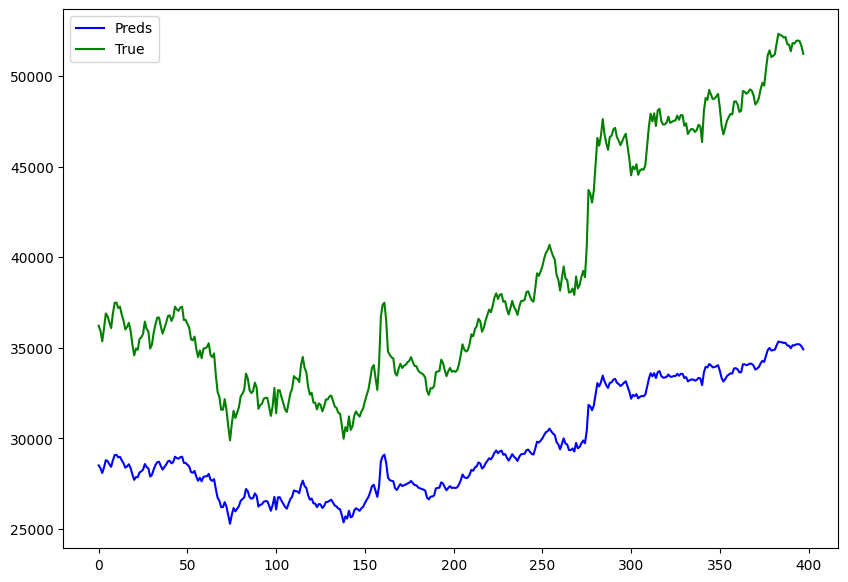

In [80]:
preds_reshaped = preds[996:].reshape(-1, 500)
true_reshaped = true[996:].reshape(-1, 500)

preds_avg = np.mean(preds_reshaped, axis=1)
true_avg = np.mean(true_reshaped, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(preds_avg, 'b', label='Preds')
plt.plot(true_avg, 'g', label='True')
plt.legend()
plt.show()